In [1]:
from photochem import __version__
print(__version__)

0.2.6


# Using Atmos reactions

This notebook shows how to use reaction networks from [Atmos](https://github.com/VirtualPlanetaryLaboratory/atmos), which is a different photochemical model.

First, we download Atmos

In [2]:
import subprocess

subprocess.run("rm -rf ./atmos".split())
subprocess.run("git clone --depth=1 https://github.com/VirtualPlanetaryLaboratory/atmos.git".split())
subprocess.run("rm -rf ./atmos/.git".split())

CompletedProcess(args=['rm', '-rf', './atmos/.git'], returncode=0)

Now we can use `atmos2yaml` to convert the reactions from the ModernEarthSimple template. Unfortunately, this function is not perfect

- "WEIRD" reactions, which are hard-coded are skipped
- Only some of the photolysis reactions will be used. Only the ones that Photochem has data for
- Particle entry for S8AER is incomplete because sometimes it forms from reactions and sometimes is forms from condensation.

In [3]:
from photochem.utils import atmos2yaml
help(atmos2yaml)

Help on function atmos2yaml in module photochem.utils._convert_atmos:

atmos2yaml(rx_file, species_file, outfile, photo_database='Photochem')
    Converts Atmos reactions to .yaml format compatable with Photochem
    
    Parameters
    ----------
    rx_file : str
        Path to Atmos reactions file (e.g. reactions.rx)
    species_file : str
        Path to Atmos species file (e.g. species.dat)
    outfile : str
        Name of output .yaml file in photochem format
    photo_database : str
        Options are "Photochem" or "Atmos". If "Photochem", then will use all
        possible photolysis reactions given the cross section data contained
        within Photochem. If "Atmos", then will photolysis reactions in
        rx_file that are possible, given Photochem cross section data.



In [4]:
atmos2yaml("atmos/PHOTOCHEM/INPUTFILES/TEMPLATES/ModernEarthSimple/reactions.rx",\
          "atmos/PHOTOCHEM/INPUTFILES/TEMPLATES/ModernEarthSimple/species.dat",\
          "ModernEarthSimple.yaml", photo_database='Photochem')

In [5]:
# fix S8AER
from photochem.utils._format import yaml, MyDumper, Loader, FormatReactions_main, FormatSettings_main

fil = open("ModernEarthSimple.yaml",'r')
data = yaml.load(fil,Loader=Loader)
fil.close()


data['particles'][1]['formation'] = "reaction"
data['particles'][1]['equation'] = "S4 + S4 (+ M) => S8AER (+ M)"
data['particles'][1]['type'] = "falloff"
data['particles'][1]['low-P-rate-constant'] = {"A": 9.0e-26, "b": -2.0, "Ea": 0.0}
data['particles'][1]['high-P-rate-constant'] = {"A": 3.0e-11, "b": 0.0, "Ea": 0.0}

data = FormatReactions_main(data)
fil = open('ModernEarthSimple.yaml','w')
yaml.dump(data,fil,Dumper=MyDumper,sort_keys=False,width=70)
fil.close()

In [6]:
settings_file = \
"""
atmosphere-grid:
  bottom: 0.0
  top: 1.0e7
  number-of-layers: 200

photolysis-grid:
  regular-grid: true
  lower-wavelength: 92.5
  upper-wavelength: 855.0
  number-of-bins: 200

planet:
  use-background-gas: true
  background-gas: N2
  surface-pressure: 1.013
  planet-mass: 5.972e27
  planet-radius: 6.371e8
  surface-albedo: 0.25
  diurnal-averaging-factor: 0.5
  solar-zenith-angle: 50.0
  diff-lim-hydrogen-escape: true
  water:
    fix-water-in-troposphere: false
    gas-rainout: true
    rainfall-rate: 1 
    tropopause-altitude: 1.1e6 
    water-condensation: true
    condensation-rate: {A: 1.0e-5, rhc: 0.01, rh0: 0.015}

particles:
- name: SO4AER
  condensation-rate: {A: 1.0e-5, rhc: 1.0, rh0: 1.05}

boundary-conditions:
- name: H2O
  lower-boundary: {type: mix, mix: 0.0175}
  upper-boundary: {type: veff, veff: 0.0}
- name: O
  lower-boundary: {type: vdep, vdep: 1.0}
  upper-boundary: {type: veff, veff: 0.0}
- name: O2
  lower-boundary: {type: mix, mix: 0.21}
  upper-boundary: {type: veff, veff: 0.0}
- name: H
  lower-boundary: {type: vdep, vdep: 1.0}
  upper-boundary: {type: veff, veff: 0.0}
- name: OH
  lower-boundary: {type: vdep, vdep: 1.0}
  upper-boundary: {type: veff, veff: 0.0}
- name: HO2
  lower-boundary: {type: vdep, vdep: 1.0}
  upper-boundary: {type: veff, veff: 0.0}
- name: H2O2
  lower-boundary: {type: vdep, vdep: 2.0e-1}
  upper-boundary: {type: veff, veff: 0.0}
- name: CO
  lower-boundary: {type: flux, flux: 3.70e11}
  upper-boundary: {type: veff, veff: 0.0}
- name: HCO
  lower-boundary: {type: vdep, vdep: 1.0}
  upper-boundary: {type: veff, veff: 0.0}
- name: H2CO
  lower-boundary: {type: vdep, vdep: 2e-1}
  upper-boundary: {type: veff, veff: 0.0}
- name: CH4
  lower-boundary: {type: flux, flux: 1e11}
  upper-boundary: {type: veff, veff: 0.0}
- name: CH3
  lower-boundary: {type: vdep, vdep: 1.0}
  upper-boundary: {type: veff, veff: 0.0}
- name: C2H6
  lower-boundary: {type: flux, flux: 9.0e8}
  upper-boundary: {type: veff, veff: 0.0}
- name: "NO"
  lower-boundary: {type: flux, flux: 1e9}
  upper-boundary: {type: veff, veff: 0.0}
- name: NO2
  lower-boundary: {type: vdep, vdep: 1.0e-3}
  upper-boundary: {type: veff, veff: 0.0}
- name: HNO
  lower-boundary: {type: vdep, vdep: 1.0}
  upper-boundary: {type: veff, veff: 0.0}
- name: H2S
  lower-boundary: {type: flux, flux: 2e8}
  upper-boundary: {type: veff, veff: 0.0}
- name: SO2
  lower-boundary: {type: vdep + dist flux, vdep: 1, flux: 9.0e9, height: 14}
  upper-boundary: {type: veff, veff: 0.0}
- name: H2SO4
  lower-boundary: {type: flux, flux: 7e8}
  upper-boundary: {type: veff, veff: 0.0}
- name: HSO
  lower-boundary: {type: vdep, vdep: 1.0}
  upper-boundary: {type: veff, veff: 0.0} 
- name: OCS
  lower-boundary: {type: flux, flux: 1.5e7}
  upper-boundary: {type: veff, veff: 0.0}
- name: HNO3
  lower-boundary: {type: vdep, vdep: 2.0e-1}
  upper-boundary: {type: veff, veff: 0.0} 
- name: N2O
  lower-boundary: {type: flux, flux: 1.53e9}
  upper-boundary: {type: veff, veff: 0.0}
- name: HO2NO2
  lower-boundary: {type: vdep, vdep: 2.0e-1}
  upper-boundary: {type: veff, veff: 0.0} 
- name: CO2
  lower-boundary: {type: mix, mix: 420e-6}
  upper-boundary: {type: veff, veff: 0.0}
- name: SO4AER
  lower-boundary: {type: vdep, vdep: 1.0e-2}
  upper-boundary: {type: veff, veff: 0.0} 
- name: S8AER
  lower-boundary: {type: vdep, vdep: 1.0e-2}
  upper-boundary: {type: veff, veff: 0.0} 
"""

In [7]:
# save the settings file
from photochem.utils._format import yaml, MyDumper, Loader, FormatSettings_main, FormatReactions_main

data = yaml.load(settings_file,Loader=Loader)
data = FormatSettings_main(data)
fil = open('settings_ModernEarthSimple.yaml','w')
yaml.dump(data,fil,Dumper=MyDumper,sort_keys=False,width=70)
fil.close()

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from photochem import Atmosphere, zahnle_earth

In [9]:
pc = Atmosphere('ModernEarthSimple.yaml',\
                "settings_ModernEarthSimple.yaml",\
                "../templates/ModernEarth/Sun_now.txt",\
                "../templates/ModernEarth/atmosphere_ModernEarth.txt")

In [10]:
# intitialize with nothing in atmosphere
init_cond = np.ones(pc.wrk.usol.shape,order='F')*1e-40
pc.var.verbose=0
pc.initialize_stepper(init_cond)

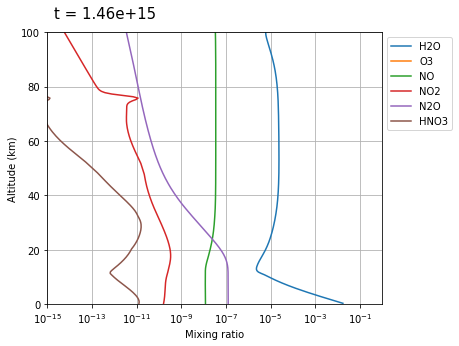

In [11]:
plt.rcParams.update({'font.size': 15})

tn = 0
while tn < 1e17:
    clear_output(wait=True)
    fig,ax = plt.subplots(1,1,figsize=[6,5])
    sol = pc.mole_fraction_dict()
    species = ['H2O','O3','NO','NO2','N2O','HNO3']
    for i,sp in enumerate(species):
        ax.plot(sol[sp],sol['alt'],label=sp)
    ax.set_xscale('log')
    ax.set_ylabel('Altitude (km)')
    ax.set_xlabel('Mixing ratio')
    ax.set_xlim(1e-15,1)
    ax.set_ylim(0,100)
    ax.grid()
    ax.text(0.02, 1.04, 't = '+'%.2e'%tn, \
        size = 15,ha='left', va='bottom',transform=ax.transAxes)
    ax.legend(ncol=1,bbox_to_anchor=(1,1.0),loc='upper left')
    plt.show()
    for i in range(10):
        tn = pc.step()

In [12]:
pc.destroy_stepper()

There is no O3! Because we are missing reactions that are labeled "WEIRD" that are relevant to making O3. These WEIRD reactions have to be implemented by hand :(

In [13]:
fil = open("ModernEarthSimple.yaml",'r')
data = yaml.load(fil,Loader=Loader)
fil.close()

for d in data['missing']:
    print(d['equation'])

H2 + O => OH + H
HO2 + HO2 => H2O2 + O2
O + O => O2
O + O2 => O3
H + CO => HCO
CO + OH => CO2 + H
CO + O => CO2
H2CO + H => H2 + HCO
H + H => H2
H + OH => H2O
CH3 + CH3 => C2H6
CH3 + H2CO => CH4 + HCO
H + NO => HNO
N + N => N2
HNO3 + OH => H2O + NO3
H + HNO => H2 + NO
C2H6 + O => C2H5 + OH
SO + O => SO2
SO3 + H2O => H2SO4
S + S => S2
S2 + OH => HSO + S
S + S2 => S3
S2 + S2 => S4
S + S3 => S4
S4 + S4 => S8
SO + HCO => HSO + CO
S + CO => OCS
CO + O1D => CO2
OCS + S => OCS2
N2O5 + M => NO3 + NO2
HO2NO2 + M => HO2 + NO2
